In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from ipywidgets import interact, FloatSlider, Label

SEED = 42


In [ ]:
url = 'https://raw.githubusercontent.com/Siddharths99/NASA-Exoplanet-Detection/refs/heads/main/data/kepler.csv'
df = pd.read_csv(url)
df_names = df[["kepler_name","kepoi_name"]].reset_index(drop=True)
print("Initial dataset size:", df.shape)
df.head(3)


Initial dataset size: (9564, 50)


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436


In [3]:
drop_cols = ["rowid","kepid","kepoi_name","kepler_name",
             "koi_pdisposition","koi_tce_delivname","ra","dec"]
df_model = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

df_model = df_model.dropna(subset=["koi_disposition"])
df_model["koi_disposition"] = df_model["koi_disposition"].str.upper().str.strip()

num_cols = df_model.select_dtypes(include=np.number).columns.tolist()
df_model[num_cols] = df_model[num_cols].fillna(df_model[num_cols].median())

print(df_model["koi_disposition"].value_counts())
print("Dataset size after cleaning:", len(df_model))


koi_disposition
FALSE POSITIVE    5023
CONFIRMED         2293
CANDIDATE         2248
Name: count, dtype: int64
Dataset size after cleaning: 9564


In [4]:
feature_cols = ["koi_period","koi_duration","koi_prad","koi_teq","koi_insol",
                "koi_impact","koi_depth","koi_steff","koi_slogg","koi_srad","koi_model_snr"]
feature_cols = [c for c in feature_cols if c in df_model.columns]

X = df_model[feature_cols]
y = df_model["koi_disposition"]

le = LabelEncoder()
y_enc = le.fit_transform(y)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=SEED, stratify=y_enc
)

smote = SMOTE(random_state=SEED)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("Train size after SMOTE:", X_train.shape)
print("Test size:", X_test.shape)


Train size after SMOTE: (12054, 11)
Test size: (1913, 11)


In [6]:
clf = RandomForestClassifier(n_estimators=200, random_state=SEED)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)

print(classification_report(y_test, y_pred, target_names=le.classes_))


                precision    recall  f1-score   support

     CANDIDATE       0.56      0.59      0.57       449
     CONFIRMED       0.78      0.83      0.80       459
FALSE POSITIVE       0.87      0.82      0.84      1005

      accuracy                           0.77      1913
     macro avg       0.73      0.75      0.74      1913
  weighted avg       0.77      0.77      0.77      1913



In [7]:
df_test = X_test.copy()
df_test["Actual"] = le.inverse_transform(y_test)
df_test["Predicted"] = le.inverse_transform(y_pred)
df_test["Probability"] = clf.predict_proba(X_test).max(axis=1)
df_test = pd.concat([df_names.iloc[df_test.index].reset_index(drop=True), df_test.reset_index(drop=True)], axis=1)

df_test.to_csv("exo_predictions_with_names.csv", index=False)
top_candidates = df_test[df_test["Predicted"].isin(["CONFIRMED","CANDIDATE"])].sort_values(by="Probability", ascending=False)
top_candidates.to_csv("top_exo_candidates_with_names.csv", index=False)


,kepler_name,Predicted,Probability,koi_prad,koi_period,koi_teq
1686,Kepler-192 b,CONFIRMED,0.995,2.76,9.926721,803.0
544,Kepler-60 c,CONFIRMED,0.990,1.84,8.919012,1023.0
466,Kepler-216 c,CONFIRMED,0.990,2.95,17.406652,814.0
1242,Kepler-104 b,CONFIRMED,0.985,2.35,11.427551,852.0
981,Kepler-624 b,CONFIRMED,0.985,2.45,14.586499,852.0
661,Kepler-245 d,CONFIRMED,0.985,3.03,36.276124,445.0
1688,Kepler-90 b,CONFIRMED,0.980,1.29,7.008218,1062.0
1306,Kepler-82 c,CONFIRMED,0.980,5.51,51.539980,450.0
770,Kepler-103 b,CONFIRMED,0.975,3.33,15.965327,872.0
1626,Kepler-198 b,CONFIRMED,0.975,2.70,17.790017,655.0


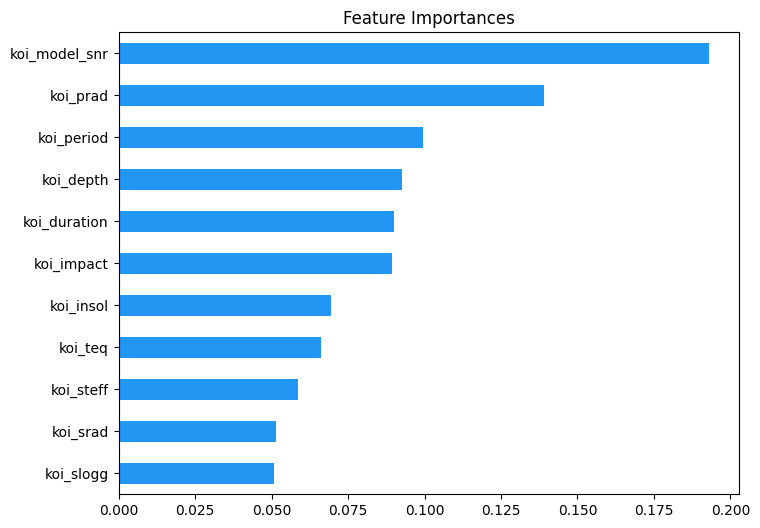

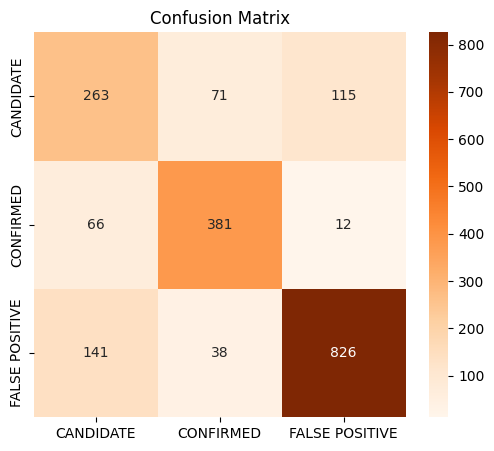

C:\Users\siddh\AppData\Local\Temp\ipykernel_20676\3311395702.py:21: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(x="Probability", y=top10.index, hue="Predicted", data=top10, dodge=False, palette=["#4CAF50","#FFC107"])


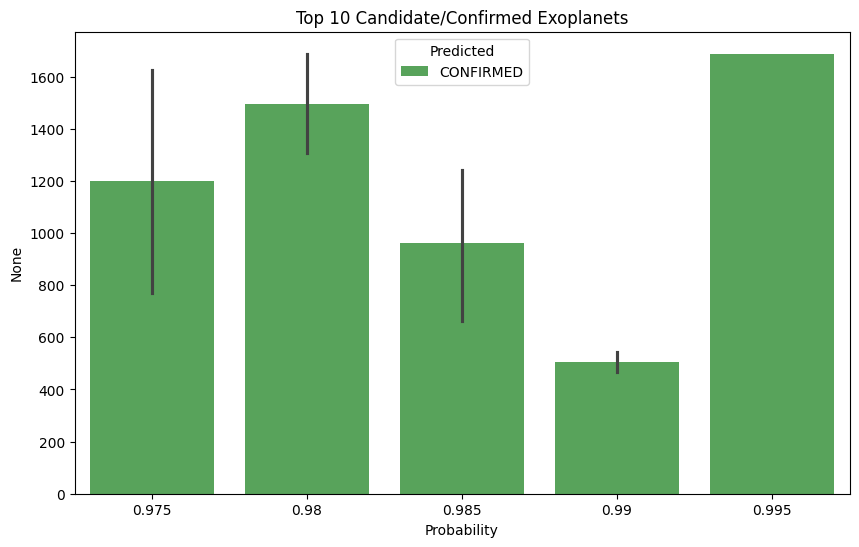

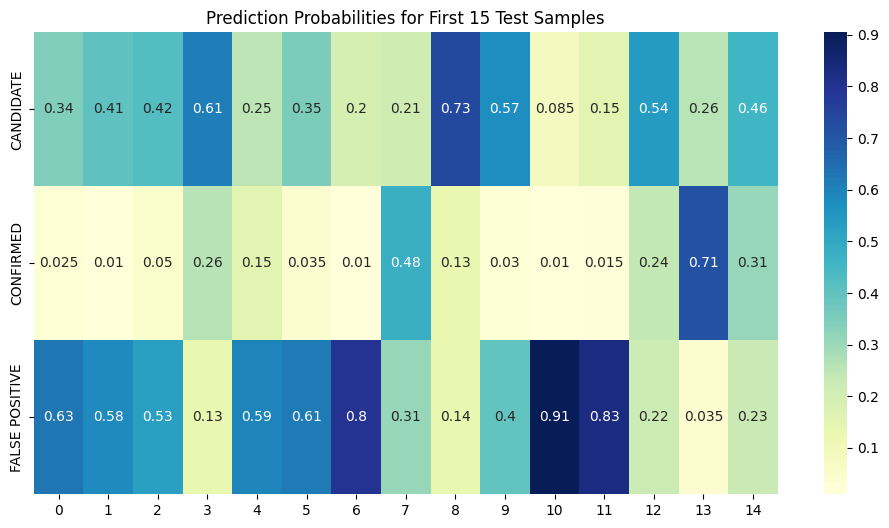

                precision    recall  f1-score   support

     CANDIDATE       0.56      0.59      0.57       449
     CONFIRMED       0.78      0.83      0.80       459
FALSE POSITIVE       0.87      0.82      0.84      1005

      accuracy                           0.77      1913
     macro avg       0.73      0.75      0.74      1913
  weighted avg       0.77      0.77      0.77      1913

Accuracy: 0.7684265551489806


In [8]:
# Top 10 candidates table
top10 = top_candidates.head(10)
display(HTML("<h3 style='color:#4CAF50'>Top 10 Candidate/Confirmed Exoplanets</h3>"))
display(top10[['kepler_name','Predicted','Probability','koi_prad','koi_period','koi_teq']])

# Feature importance
plt.figure(figsize=(8,6))
feat_importances.sort_values().plot(kind='barh', color="#2196F3")
plt.title("Feature Importances")
plt.show()

# Confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.show()

# Top candidate bar chart
plt.figure(figsize=(10,6))
sns.barplot(x="Probability", y=top10.index, hue="Predicted", data=top10, dodge=False, palette=["#4CAF50","#FFC107"])
plt.title("Top 10 Candidate/Confirmed Exoplanets")
plt.show()

# Probability heatmap
proba_df = pd.DataFrame(clf.predict_proba(X_test), columns=le.classes_)
plt.figure(figsize=(12,6))
sns.heatmap(proba_df.head(15).T, annot=True, cmap="YlGnBu")
plt.title("Prediction Probabilities for First 15 Test Samples")
plt.show()

# Classification report and accuracy
print(classification_report(y_test, clf.predict(X_test), target_names=le.classes_))
print("Accuracy:", clf.score(X_test, y_test))


In [9]:
def predict_new_exoplanet(features_dict):
    df_new = pd.DataFrame([features_dict])
    for col in feature_cols:
        if col not in df_new.columns:
            df_new[col] = 0
    df_new = df_new[feature_cols]
    pred_class = le.inverse_transform(clf.predict(df_new))[0]
    pred_prob = clf.predict_proba(df_new).max()
    return pred_class, pred_prob

def interactive_predict(koi_period, koi_duration, koi_prad, koi_teq, koi_insol,
                        koi_impact, koi_depth, koi_steff, koi_slogg, koi_srad, koi_model_snr):
    features_dict = {
        "koi_period": koi_period,
        "koi_duration": koi_duration,
        "koi_prad": koi_prad,
        "koi_teq": koi_teq,
        "koi_insol": koi_insol,
        "koi_impact": koi_impact,
        "koi_depth": koi_depth,
        "koi_steff": koi_steff,
        "koi_slogg": koi_slogg,
        "koi_srad": koi_srad,
        "koi_model_snr": koi_model_snr
    }
    pred_class, pred_prob = predict_new_exoplanet(features_dict)
    display(Label(f"Predicted Class: {pred_class}"))
    display(Label(f"Prediction Probability: {pred_prob:.2f}"))

interact(interactive_predict,
         koi_period=FloatSlider(value=365, min=0, max=1000, step=0.1),
         koi_duration=FloatSlider(value=10, min=0, max=50, step=0.1),
         koi_prad=FloatSlider(value=1, min=0, max=20, step=0.1),
         koi_teq=FloatSlider(value=300, min=50, max=5000, step=10),
         koi_insol=FloatSlider(value=1, min=0, max=1000, step=0.1),
         koi_impact=FloatSlider(value=0, min=0, max=5, step=0.01),
         koi_depth=FloatSlider(value=0.01, min=0, max=5, step=0.01),
         koi_steff=FloatSlider(value=5800, min=2000, max=10000, step=10),
         koi_slogg=FloatSlider(value=4.4, min=0, max=6, step=0.01),
         koi_srad=FloatSlider(value=1.0, min=0, max=10, step=0.01),
         koi_model_snr=FloatSlider(value=10, min=0, max=100, step=1)
)


interactive(children=(FloatSlider(value=365.0, description='koi_period', max=1000.0), FloatSlider(value=10.0, …

<function __main__.interactive_predict(koi_period, koi_duration, koi_prad, koi_teq, koi_insol, koi_impact, koi_depth, koi_steff, koi_slogg, koi_srad, koi_model_snr)>